In [198]:
# Data update functionality
import os

from fabric import ThreadingGroup,Connection
from fabric.transfer import Transfer

# global configuration parameters
experiment_type = "random"
exploration_name = "Exploration_2"
hosts = ["52.13.145.44", "52.89.179.9", "54.191.161.231", "54.218.172.167", "54.218.29.151", "34.222.0.168","18.237.96.142","54.68.198.213"]
key_file_loc = "/Users/sfeygi/.ssh/beam_competitions_key.pem"
dest_root = "/Users/sfeygi/current_code/others/prize_starter_kit/search-output/{}/{}/".format(exploration_name,experiment_type)

def connect_parallel(hosts,key_file_loc):
    return ThreadingGroup(*hosts,user='ubuntu',connect_kwargs={"key_filename":[key_file_loc]})

def connect_single(host, key_file_loc):
    return Connection(host,user='ubuntu',connect_kwargs={"key_filename":[key_file_loc]})

def run(cmd, connection):
    return connection.run(cmd)

def run_n(cmd, connections):
    return [run(cmd,connection) for connection in connections]

def rsync_results(hostname, host_ip, key_file_loc, dest_root,exploration_name,experiment_type):
    experiment_type = 'random_inputs' if experiment_type == 'random' else experiment_type
    return os.system(
        'rsync -avz -e "ssh -i {key_file_loc}" ubuntu@{host_ip}:/home/ubuntu//Uber-Prize-Starter-Kit/search-output-{exploration_name}-{experiment_type}/ {dest_root}{hostname} --exclude="*/ITERS/" --exclude="*/output*" --exclude="*/competition/viz/" --exclude="*/summaryStats/"'.format(
            exploration_name=exploration_name,experiment_type=experiment_type,dest_root=dest_root,key_file_loc=key_file_loc, hostname=hostname, host_ip=host_ip))

# global other
host_names = ["host{}".format(str(i + 1)) for i in range(len(hosts))]
connection = connect_parallel(hosts,key_file_loc)

In [17]:
# try:
#     run('cd /home/ubuntu/Uber-Prize-Starter-Kit/utilities &&  \
#         git pull origin vgv/#55-adapt_ramdom_search', connection)
# except UnexpectedExit:
#     print("Already pulled in latest!")
# Ensure that docker image on server is latest (somewhat orthogonal to this notebook, but leaving here for now)
run('docker pull beammodel/beam-competition:0.0.1-SNAPSHOT',connection)


0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
Digest: sha256:59c85113ca31d695202a74c9c9db99cd44a8e720af8e3d07e1b443e7a44da0a2
Status: Image is up to date for beammodel/beam-competition:0.0.1-SNAPSHOT
0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
Digest: sha256:59c85113ca31d695202a74c9c9db99cd44a8e720af8e3d07e1b443e7a44da0a2
Status: Image is up to date for beammodel/beam-competition:0.0.1-SNAPSHOT
0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
Digest: sha256:59c85113ca31d695202a74c9c9db99cd44a8e720af8e3d07e1b443e7a44da0a2
Status: Image is up to date for beammodel/beam-competition:0.0.1-SNAPSHOT
0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
Digest: sha256:59c85113ca31d695202a74c9c9db99cd44a8e720af8e3d07e1b443e7a44da0a2
Status: Image is up to date for beammodel/beam-competition:0.0.1-SNAPSHOT
0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
Digest: sha256:59c85113ca31d695202a74c9c9db99cd44a8e720af8e3d07e1b443e7a44da0a2
Status: Image is up to d

{<Connection host=34.222.0.168 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=18.237.96.142 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.218.29.151 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.191.161.231 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.68.198.213 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=52.89.179.9 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=52.13.145.44 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.218.172.167 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>}

In [18]:
# Pull latest results from server
[rsync_results(hostname, host_ip, key_file_loc,dest_root,exploration_name,experiment_type) for hostname, host_ip in list(zip(host_names, hosts))]

[0, 0, 0, 0, 0, 0, 0, 0]

In [19]:
import pandas as pd
import seaborn as sns
# import dask.dataframe as dd
from collections import defaultdict
import re
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [20]:
%matplotlib inline

In [21]:
# Parsing utilities
def split_range(range_repr):
    """
    Split's out a mathematial range representation into its component bounds.
    
    Exclusive ('(',')') bounds will have the left and/or right bounds properly
    augmented with +1 and -1, respectively. Inclusive bounds ('[',']') will remain
    as written.
    
    Parameters
    ----------
    range_repr : str
        A formatted representation of the range with exclusive and inclusive
        bounds represented as '(',')' and/or '[',']', respectively, for example,
        the range "(300:500]" represents all numbers between 300 (exclusive) and 500
        (inclusive).
    
    Returns
    -------
    str
        The input range representation as pair of integers with the ':' remaining to permit
        easy splitting with the series `str.split` function when the `expand` argument is `True`.
    
    Examples
    --------
    >>> split_range("(47000:202000]")
    '47001:202000'
    >>> split_range("(47000:202000]")
    '155000:176000'
    
    """
    if isinstance(range_repr,float):
        return "0:120"
    l,r = range_repr.strip("(),[]").split(":")
    l = int(l) + 1 if range_repr[0] is '(' else int(l) + 0
    r = int(r) - 1 if range_repr[-1] is ')' else int(r) + 0
    return "{}:{}".format(l,r)

# input_db = pd.concat(all_input_dfs).set_index("output_key")
def concat_and_set_index(df,name):
    return pd.concat(df[name]).set_index("output_key")
def expand_range_column(in_df,field):
    in_series = in_df.loc[:,field]
    in_df = in_series.apply(split_range).str.split(":",expand=True)
    in_df.columns = ["{}_low".format(field),"{}_high".format(field)]
#     in_df
    return in_df

def split_input_range(input_df,input_fields):
    tmp_res = []
    for input_field in input_fields:
        split_input_field=expand_range_column(input_df,input_field)
        input_df.drop(input_field,axis=1,inplace=True)
        tmp_res.append(split_input_field)
    input_type_df = pd.concat(tmp_res,axis=1)
    return pd.concat([input_df,input_type_df],axis=1)

def merge_input_type_df_with_score(input_df,scores_df,score_type):
    sub_scores = scores_df.loc[score_type]
    score_df = pd.merge(sub_scores,input_df,how="outer",right_index=True,left_on="output_key").set_index("output_key")
    return score_df.dropna(axis=0)

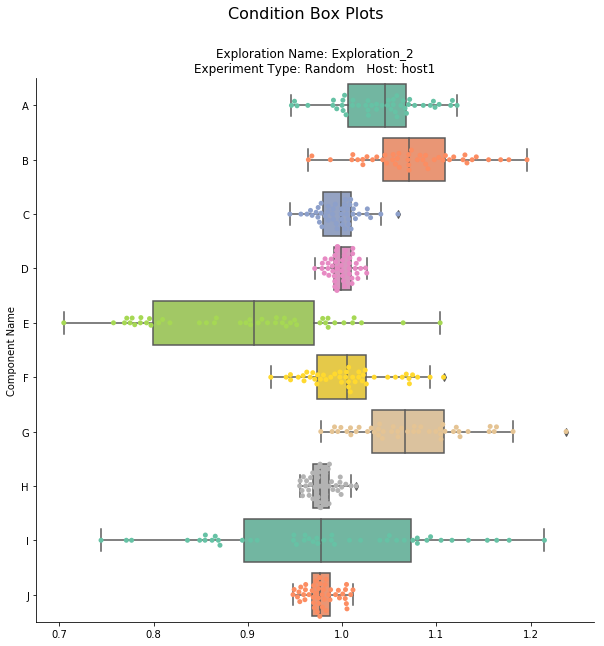

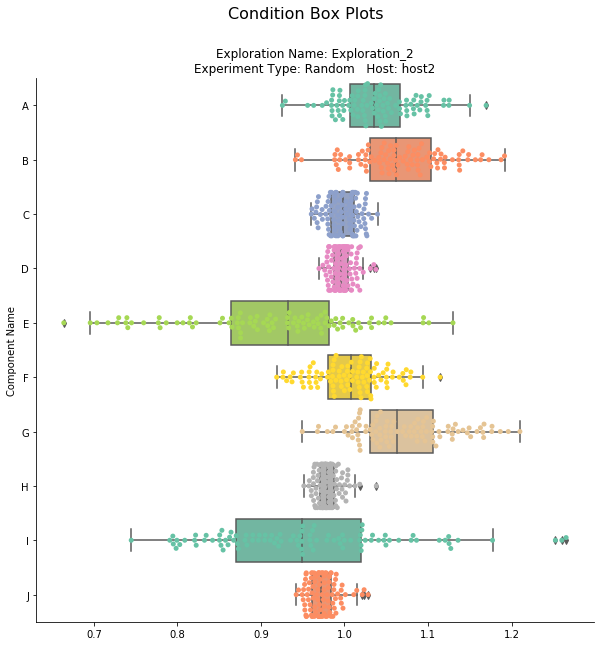

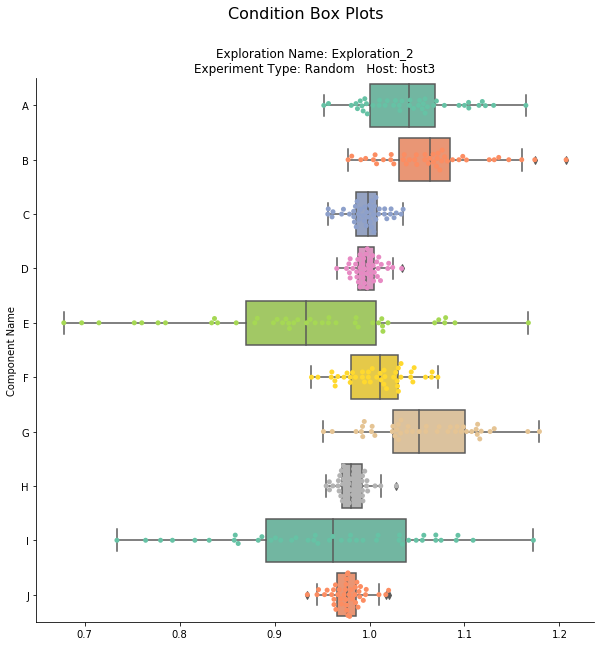

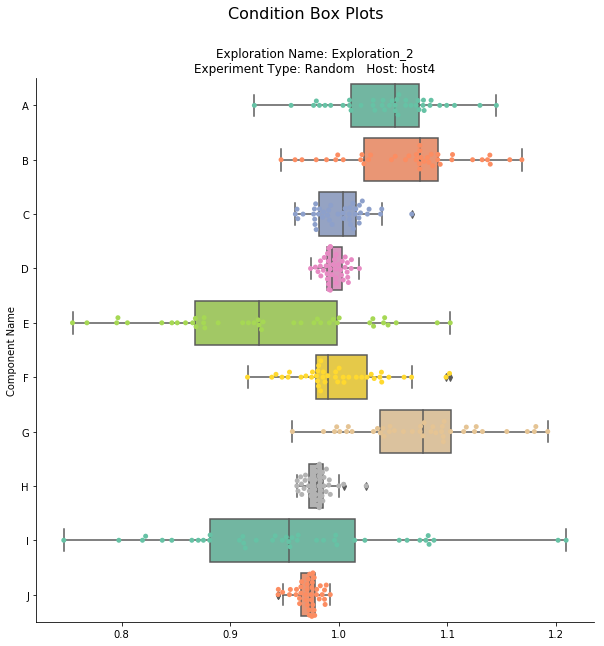

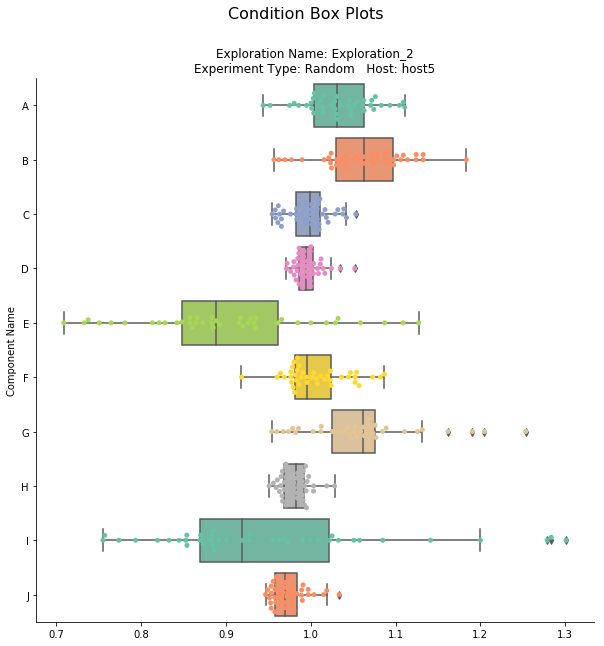

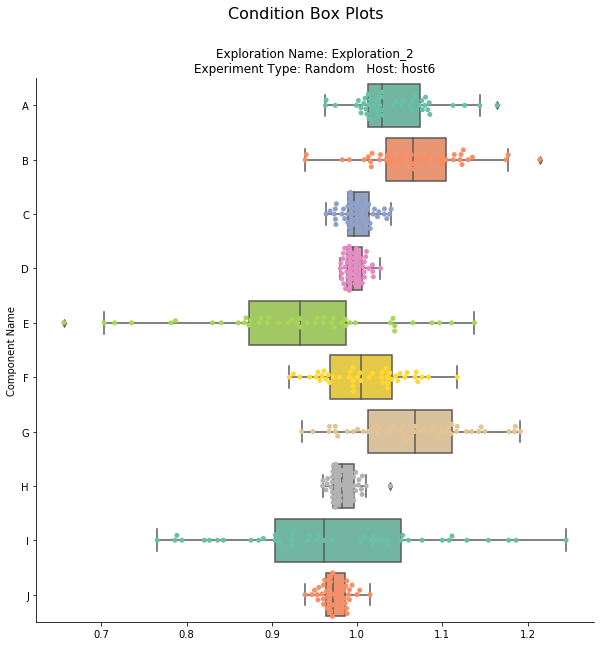

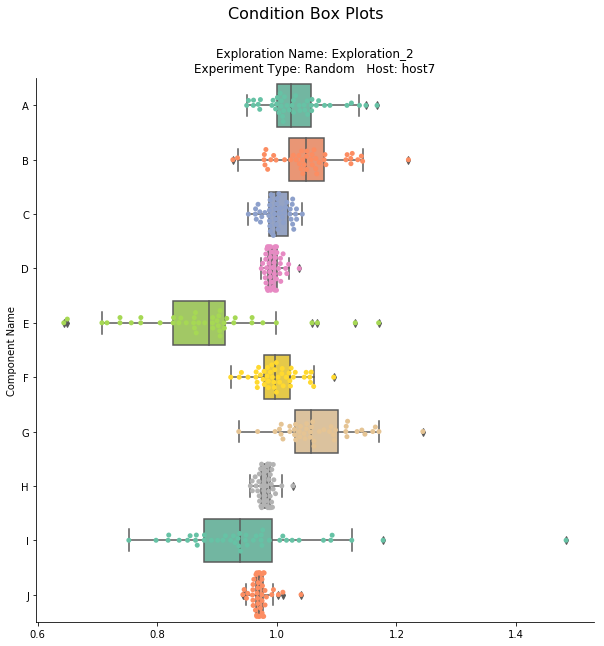

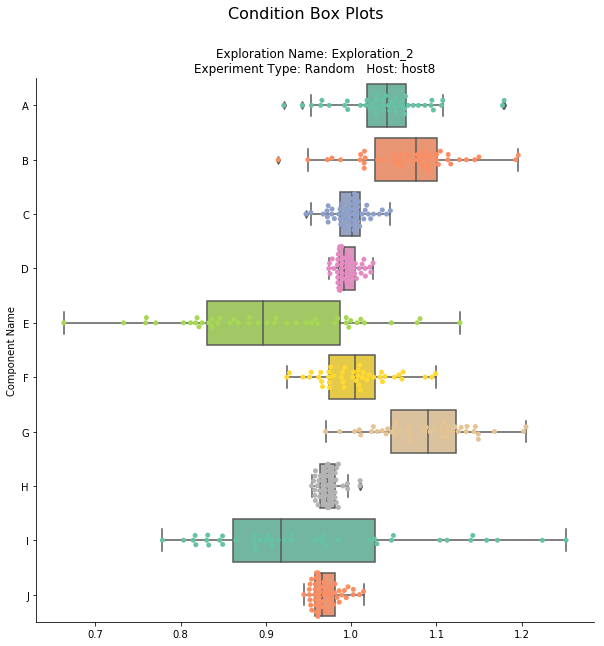

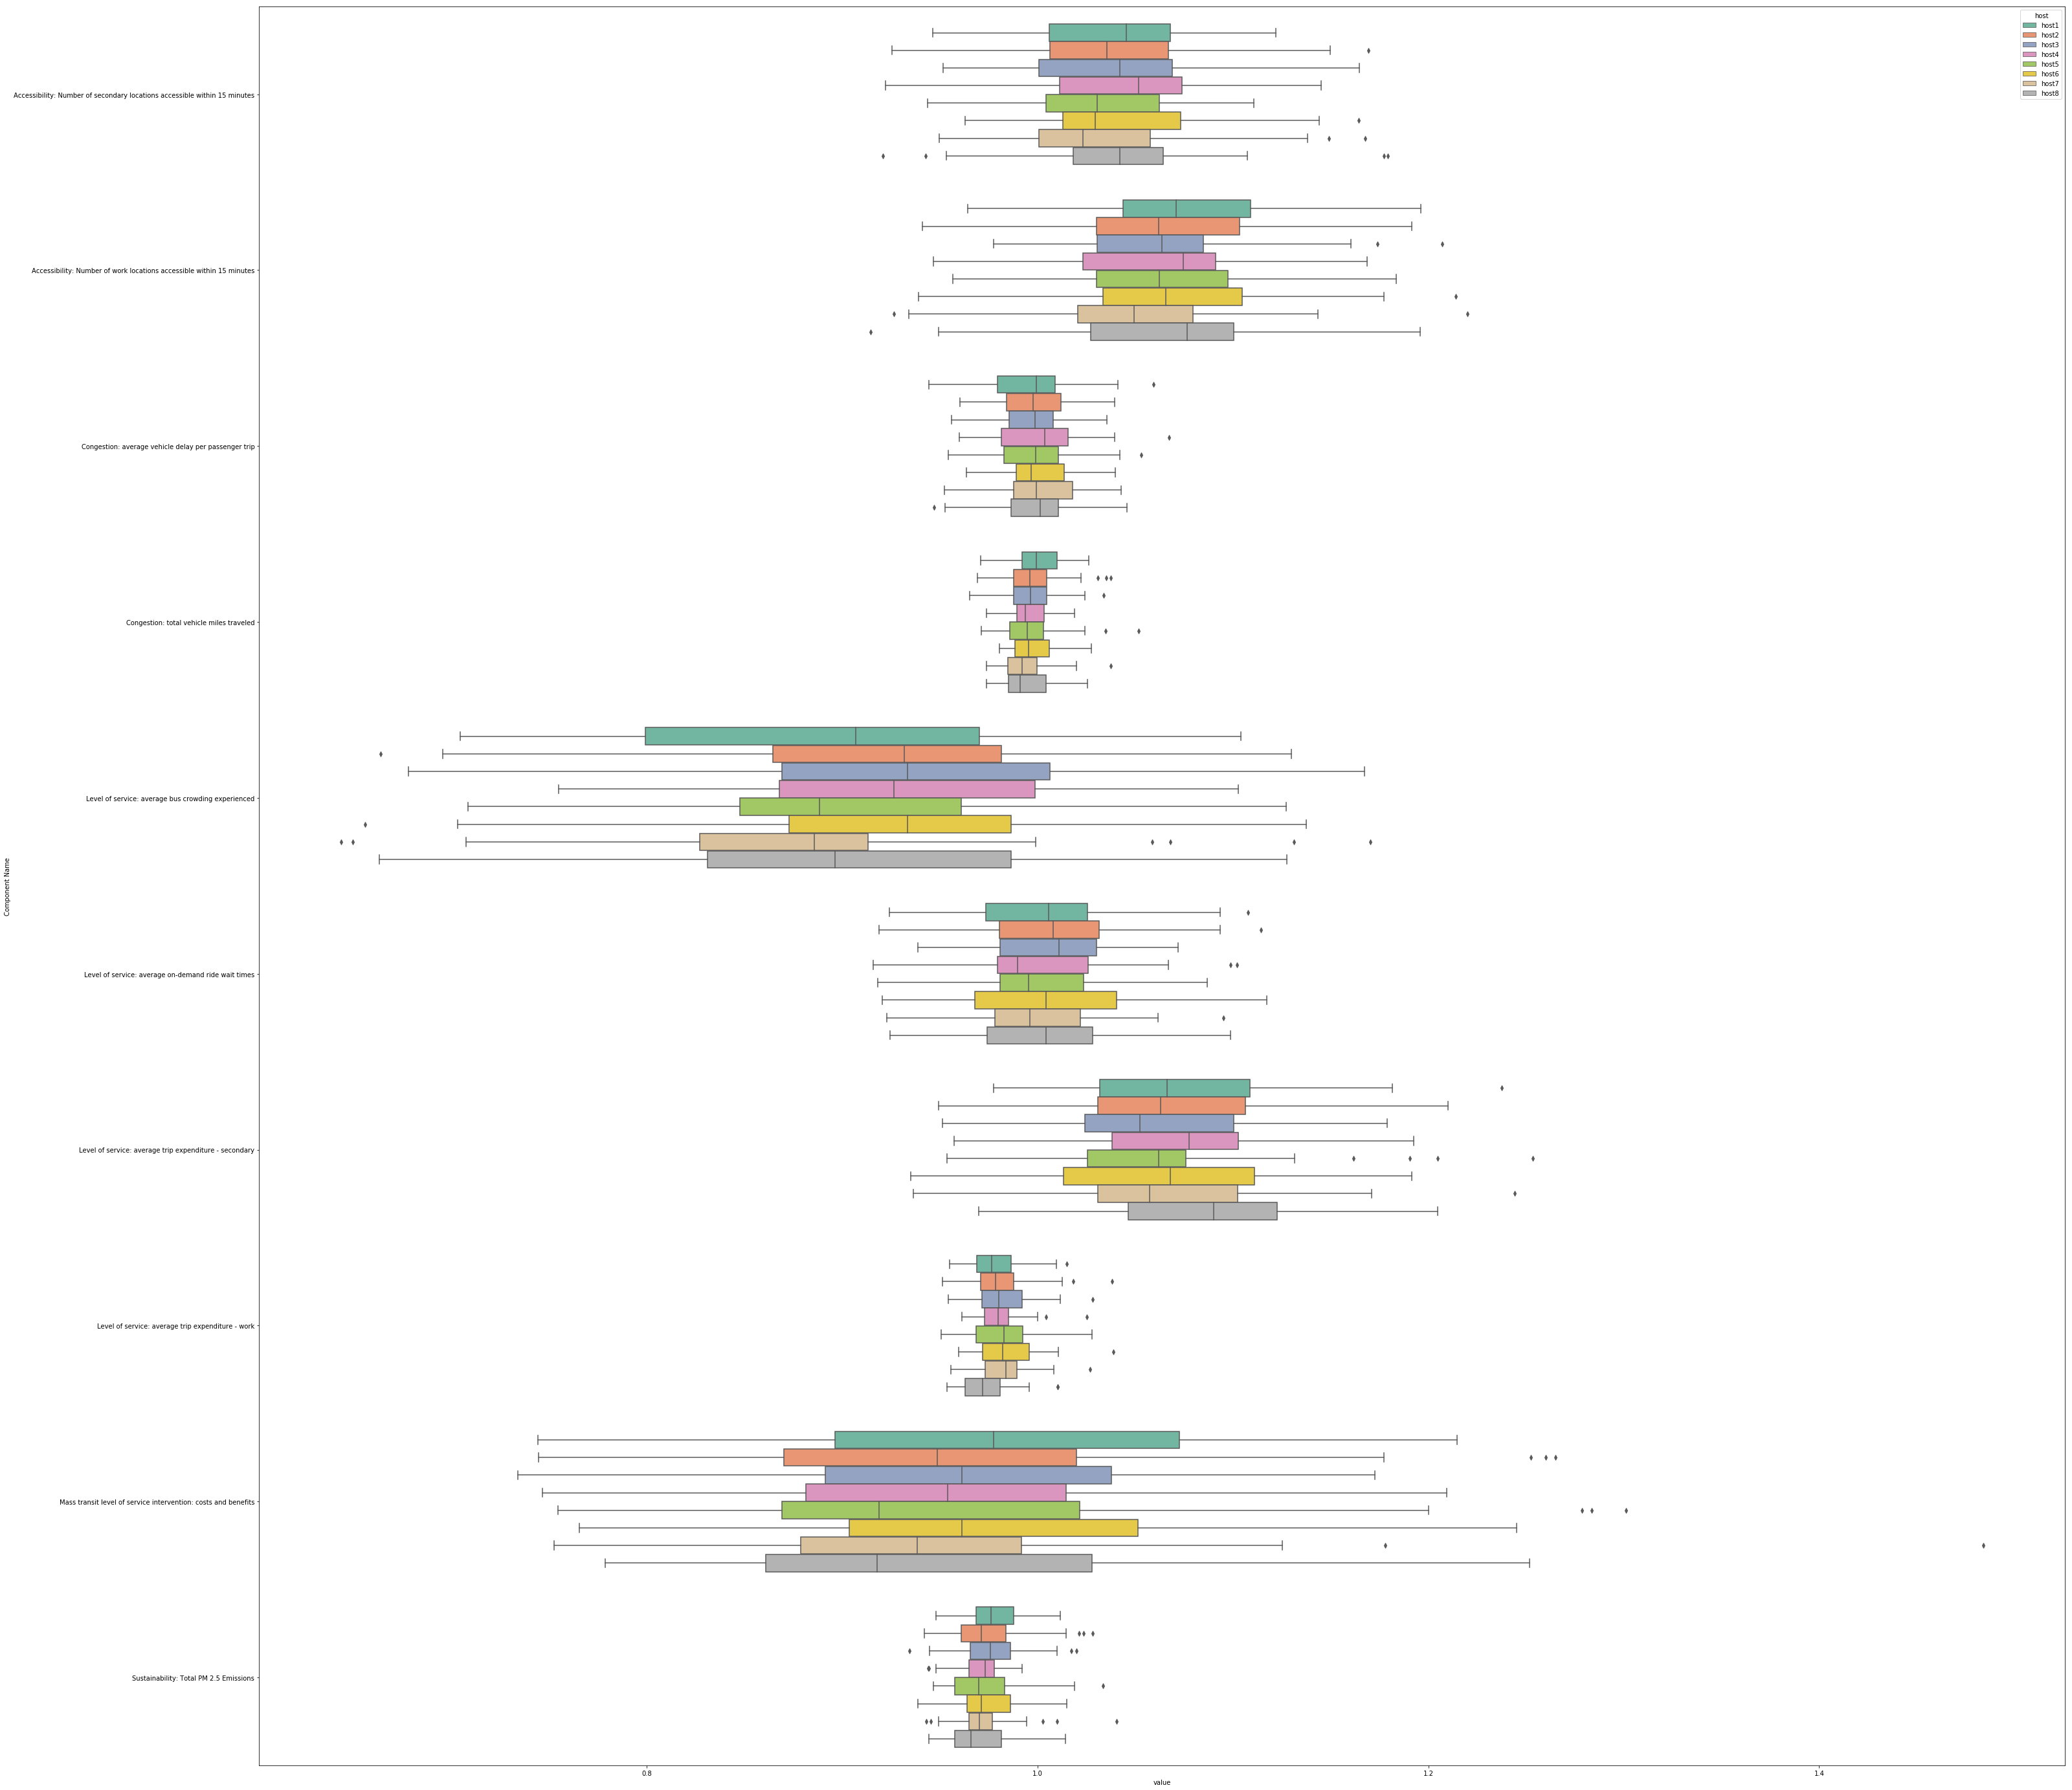

In [186]:
# collect, parse, and concatenate scores as well as plot by condition
import glob
experiment_types = ['random']
exploration_name = 'Exploration_2'
wide_score_dfs = []
for experiment_type in experiment_types:

    scores_dfs={}
    for host in host_names:
        try:
            common="../search-output/{}/{}/{}/".format(exploration_name,experiment_type,host)
            output_dirs = glob.glob(common+"output*/sioux_faux/sioux_faux-15k*/competition/")


            sub_score_dfs = []
            all_input_dfs = defaultdict(list)
            SUBMISSION_INPUTS_DIR_NAME = "submission-inputs/"
            SUB_SCORE_NAME = "submissionScores.csv"
            input_names = ("FrequencyAdjustment","ModeIncentives","MassTransitFares","VehicleFleetMix")

            for output_dir in output_dirs:
                # Load sub_score_dfs
                sub_score_file = output_dir + SUB_SCORE_NAME
                if not Path(sub_score_file).is_file():
                    continue
                score_df = pd.read_csv(sub_score_file,index_col="Component Name")
                output_key = re.findall("^.*output[_|-](.*?)(?:/sioux.*)$",output_dir)[0]
                if "RS" not in output_key:  # filter out old runs for now
                    continue
                score_df.loc[:,"output_key"] = output_key
                sub_score_dfs.append(score_df[["Raw Score","output_key"]])

                for input_name in input_names:
                    input_file = output_dir + SUBMISSION_INPUTS_DIR_NAME +"/"+ input_name+".csv"
                    if input_name == 'ModeIncentives':
                        input_df = pd.read_csv(input_file,dtype={'age':str})
                    else:
                        input_df = pd.read_csv(input_file)
                    if input_df.shape[0] == 0:
                        continue
                    input_df.loc[:,"output_key"] = output_key
                    input_df.index.name = 'obs_num'
                    all_input_dfs[input_name].append(input_df)


            freq_df = concat_and_set_index(all_input_dfs,"FrequencyAdjustment").drop('exact_times',axis=1)
            mode_df = concat_and_set_index(all_input_dfs,"ModeIncentives")
            ptfare_df = concat_and_set_index(all_input_dfs,"MassTransitFares")
            vfm_df = concat_and_set_index(all_input_dfs,"VehicleFleetMix").drop("agencyId",axis=1)

            trip_id_factors = pd.factorize(freq_df.loc[:,"trip_id"])
            freq_df.loc[:,"trip_id"]=trip_id_factors[0]

            mode_factors = pd.factorize(mode_df.loc[:,"mode"])
            mode_df.loc[:,"mode"]=mode_factors[0]

            a,b = pd.factorize(list(set(ptfare_df.loc[:, "routeId"].values).union(set(ptfare_df.loc[:,"routeId"]))))
            mapping = dict(zip(b,a))
            ptfare_df.loc[:,"routeId"]=ptfare_df.loc[:,"routeId"].apply(lambda x: mapping[x])
            vfm_df.loc[:, "routeId"] = vfm_df.loc[:, "routeId"].apply(lambda x: mapping[x])

            vehicle_type_factors = pd.factorize(vfm_df.loc[:,"vehicleTypeId"])
            vfm_df.loc[:,"vehicleTypeId"] = vehicle_type_factors[0]

            input_type = "ModeIncentives"
            input_fields = ["income","age"]
            mode_df = split_input_range(mode_df.copy(),input_fields)

            input_type = "MassTransitFares"
            input_fields = ["age"]
            ptfare_df = split_input_range(ptfare_df.copy(),input_fields)

            scores_df = pd.concat(sub_score_dfs)

            score_type = "Submission Score"
            freq_subscore_df = merge_input_type_df_with_score(freq_df,scores_df,score_type)
            mode_subscore_df = merge_input_type_df_with_score(mode_df,scores_df,score_type)
            ptfare_subscore_df = merge_input_type_df_with_score(ptfare_df,scores_df,score_type)
            vfm_subscore_df = merge_input_type_df_with_score(vfm_df,scores_df,score_type)

            freq_subscore_df=freq_subscore_df[freq_subscore_df["Raw Score"]>0]
            scores_df_wide = scores_df.reset_index().pivot(index='output_key',columns='Component Name',values='Raw Score')
            scores_dfs[host] = scores_df_wide
            fig = plt.figure(figsize=(10,10))
            
            # For plotting:
            
            sns.boxplot(data=scores_df_wide.drop("Submission Score",axis=1),orient='h',palette='Set2')
            sns.swarmplot(data=scores_df_wide.drop("Submission Score",axis=1),orient='h',palette='Set2',color=".25")
            axis = fig.axes[0]
        #     axis.set_xlim(-0.25,5.0)
            plt.suptitle('Condition Box Plots',fontsize=16)
            plt.title("Exploration Name: {}\nExperiment Type: {}   Host: {}".format(exploration_name, experiment_type.title(),host))
            axis.set_yticklabels(['A','B','C','D','E','F','G','H','I','J'])
            sns.despine()
            plt.show()

            fig.savefig("img/{}/{}/{}.png".format(exploration_name,experiment_type, host),format="png",dpi=150)
            plt.close()
        except ValueError:
            pass
    for k,df in scores_dfs.items():
        df['host'] = k
    wide_scores = pd.concat(list(scores_dfs.values()),axis=0)
    wide_scores = wide_scores.drop(['Submission Score','host'],axis=1).astype('float')
    wide_scores.to_csv('img/{}/wide-scores_{}_{}.csv'.format(exploration_name,experiment_type,exploration_name,experiment_type))

    # Plot the full distribution across worker nodes
    grouped = pd.concat(list(scores_dfs.values()))
    melted=pd.melt(grouped.drop("Submission Score",axis=1),id_vars='host')
    fig = plt.figure(figsize=(50,50))

    sns.boxplot(y='Component Name',x='value',hue='host',data=melted,orient='h',palette='Set2')
    fig.savefig('img/{}/{}/grouped.png'.format(exploration_name,experiment_type),dpi=300)
    
    wide_score_dfs.append(wide_scores)
wide_scores = pd.concat(wide_score_dfs,axis=0)

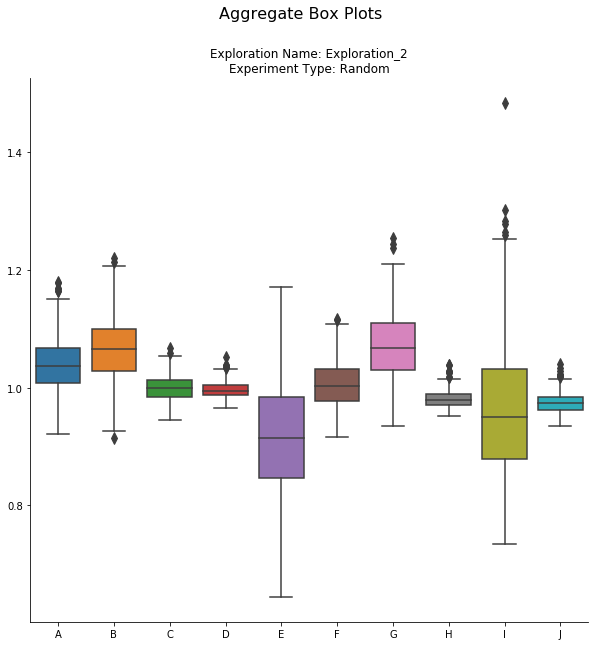

In [187]:
fig = plt.figure(figsize=(10,10))
columns = ['A','B','C','D','E','F','G','H','I','J']
ser = []
for i in range(10):
    ser.append(wide_scores.T.iloc[i].values)
sns.boxplot(y=ser,x=columns,orient='v',fliersize=8)
plt.suptitle('Aggregate Box Plots',fontsize=16)
plt.title("Exploration Name: {}\nExperiment Type: {}".format(exploration_name, experiment_type.title()))
sns.despine()
fig.savefig('img/{}/{}/aggregate_box.png'.format(exploration_name,experiment_type),dpi=300)

In [244]:
wide_scores.iloc[np.argmin(wide_scores.values,0)].loc[:,'Congestion: average vehicle delay per passenger trip':]

Component Name,Congestion: average vehicle delay per passenger trip,Congestion: total vehicle miles traveled,Level of service: average bus crowding experienced,Level of service: average on-demand ride wait times,Level of service: average trip expenditure - secondary,Level of service: average trip expenditure - work,Mass transit level of service intervention: costs and benefits,Sustainability: Total PM 2.5 Emissions
output_key,,,,,,,,
C9_RS39-hx_wyfd_,0.977314,0.986141,0.994175,0.988375,1.088159,0.969789,0.963594,0.962542
C9_RS39-hx_wyfd_,0.977314,0.986141,0.994175,0.988375,1.088159,0.969789,0.963594,0.962542
C9_RS37-9v1g91an,0.944626,0.985138,0.892064,0.924416,1.157157,0.958072,0.744334,0.952752
C9_RS26-9519154u,0.970624,0.965495,0.752261,1.058955,1.024664,0.961431,0.779935,0.934568
C9_RS3-v3v5adfq,1.003292,0.989124,0.643774,1.027708,1.004542,0.968049,0.878586,0.959996
C9_RS3-nxnd4wf4,1.015650,0.997603,0.805430,0.915974,1.078600,0.978536,1.209316,0.988481
C9_RS14-lvt60od1,0.968421,0.995404,0.960715,0.995501,0.935086,0.979805,0.961275,0.953054
C9_RS20-f6emcqyw,0.967944,0.972042,0.708733,1.001173,1.059078,0.950878,0.886156,0.952723
C9_RS13-w3nwrgo9,0.986014,0.979592,0.678052,0.959675,1.005624,0.996839,0.734006,0.952630


In [242]:
dict(zip(best_scores.columns.values.tolist(),best_scores.index.values.tolist()))

{'Congestion: average vehicle delay per passenger trip': 'C9_RS39-hx_wyfd_',
 'Congestion: total vehicle miles traveled': 'C9_RS39-hx_wyfd_',
 'Level of service: average bus crowding experienced': 'C9_RS37-9v1g91an',
 'Level of service: average on-demand ride wait times': 'C9_RS26-9519154u',
 'Level of service: average trip expenditure - secondary': 'C9_RS3-v3v5adfq',
 'Level of service: average trip expenditure - work': 'C9_RS3-nxnd4wf4',
 'Mass transit level of service intervention: costs and benefits': 'C9_RS14-lvt60od1',
 'Sustainability: Total PM 2.5 Emissions': 'C9_RS20-f6emcqyw'}

In [243]:
dict(zip(best_scores.columns.values.tolist(),np.diag(best_scores.values).tolist()))

{'Congestion: average vehicle delay per passenger trip': 0.9773135169021758,
 'Congestion: total vehicle miles traveled': 0.9861411384835108,
 'Level of service: average bus crowding experienced': 0.8920643163554918,
 'Level of service: average on-demand ride wait times': 1.058955393422358,
 'Level of service: average trip expenditure - secondary': 1.0045422272396602,
 'Level of service: average trip expenditure - work': 0.978535528496472,
 'Mass transit level of service intervention: costs and benefits': 0.9612748878843798,
 'Sustainability: Total PM 2.5 Emissions': 0.9527228645742408}

In [188]:
import pandas as pd, numpy as np
# wide_scores = pd.read_csv("img/random/wide-scores_random.csv")
wide_scores.describe()

Component Name,Accessibility: Number of secondary locations accessible within 15 minutes,Accessibility: Number of work locations accessible within 15 minutes,Congestion: average vehicle delay per passenger trip,Congestion: total vehicle miles traveled,Level of service: average bus crowding experienced,Level of service: average on-demand ride wait times,Level of service: average trip expenditure - secondary,Level of service: average trip expenditure - work,Mass transit level of service intervention: costs and benefits,Sustainability: Total PM 2.5 Emissions
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,1.039035,1.065511,0.998611,0.996690,0.910010,1.005341,1.070238,0.980423,0.960827,0.974047
std,0.046604,0.054488,0.021182,0.013200,0.103068,0.040212,0.059073,0.014539,0.114318,0.016847
min,0.921023,0.914542,0.944626,0.965495,0.643774,0.915974,0.935086,0.950878,0.734006,0.934568
25%,1.007658,1.028572,0.984153,0.987043,0.846353,0.977447,1.029812,0.970596,0.878586,0.961649
50%,1.036925,1.065024,0.999104,0.994937,0.913386,1.003170,1.067052,0.979574,0.950041,0.972899
75%,1.067527,1.100034,1.012528,1.004835,0.983355,1.031379,1.109469,0.989205,1.031097,0.983151
max,1.179306,1.220129,1.067178,1.051823,1.170317,1.117352,1.253429,1.038789,1.483839,1.040557


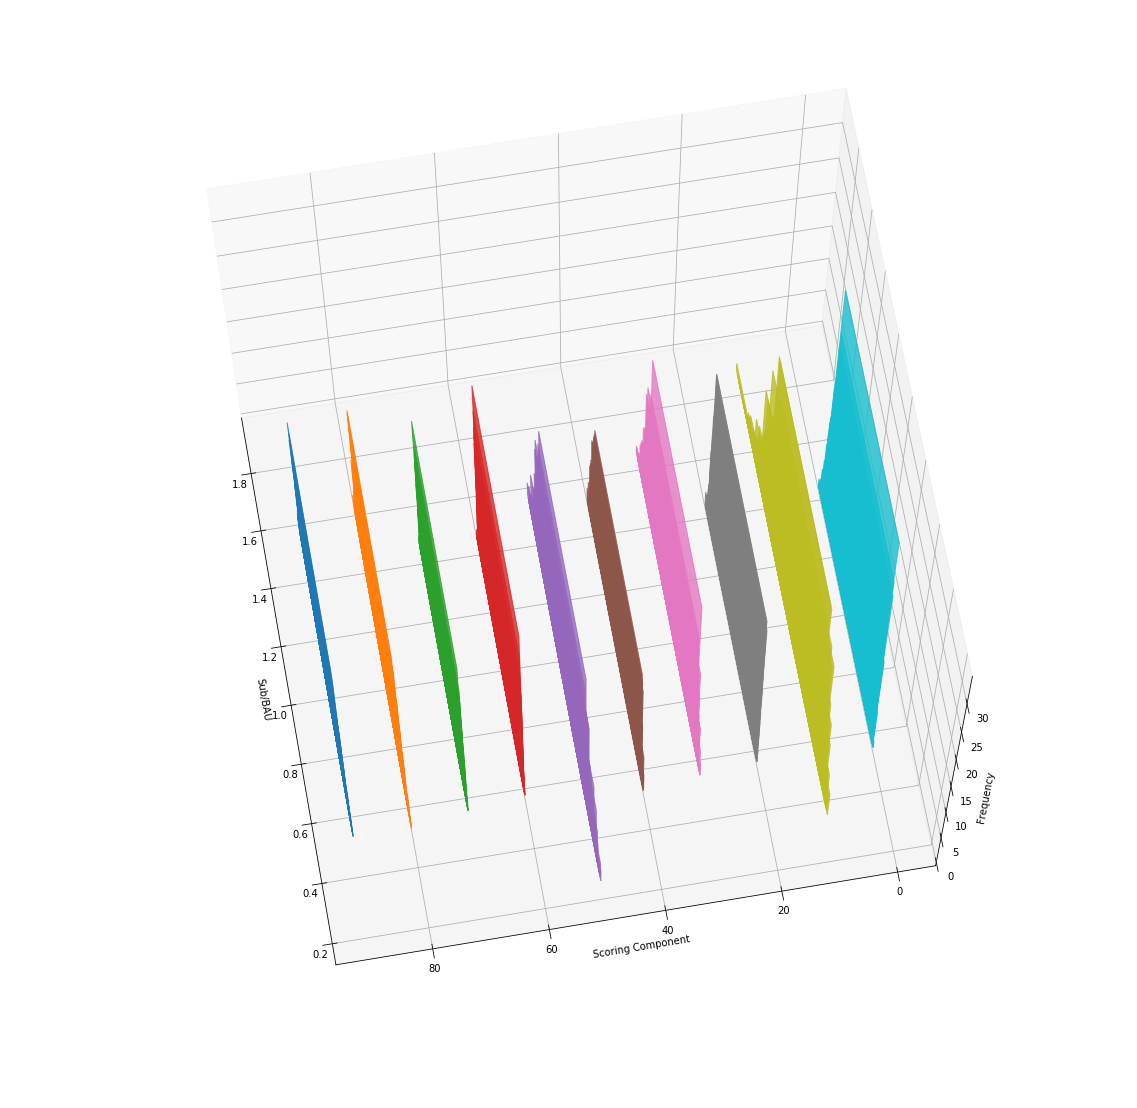

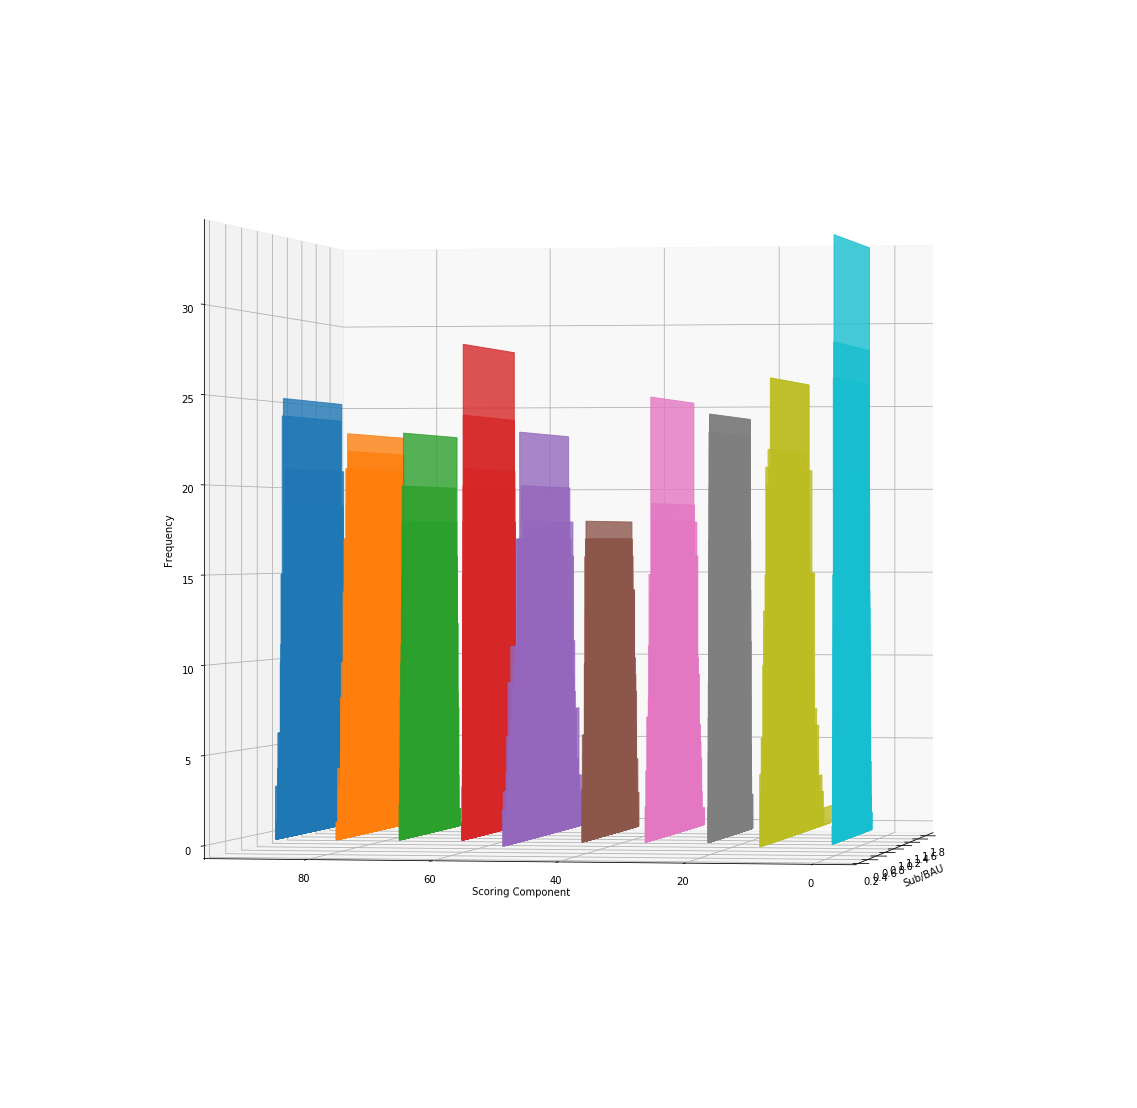

In [189]:
colors = sns.color_palette("tab10",10)



views = [(70,170),(0,190)]

for m,n in enumerate(views):
    fig = plt.figure(num=m,figsize=(20,20))
    ax = fig.add_subplot(1,1,1, projection='3d')
    nbins = 50
    for i,z in enumerate([90,80,70,60,50,40,30, 20, 10, 0]):
        ys = wide_scores.T.iloc[i]

        hist, bins = np.histogram(ys, bins=nbins)
        xs = (bins[:-1] + bins[1:])/2

        ax.bar(xs, hist, zs=z, zdir='y', color=colors[i], ec=colors[i], alpha=0.8)

    ax.set_xlabel('Sub/BAU')
    ax.set_ylabel('Scoring Component')
    ax.set_zlabel('Frequency')

# ax.set_yticklabels(['A','B','C','D','E','F','G','H','I','J'])

    ax.view_init(n[0], n[1])
    plt.show()



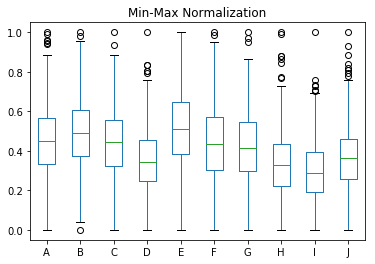

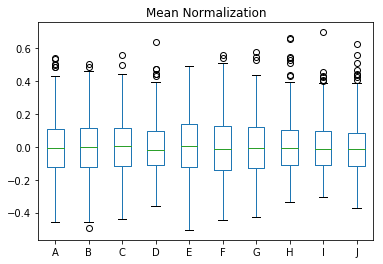

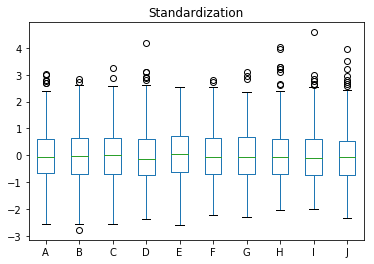

In [190]:
columns = ['A','B','C','D','E','F','G','H','I','J']
mins = np.nanmin(wide_scores.values.astype(float),axis=0)
maxs = np.nanmax(wide_scores.values.astype(float),axis=0)
denom = maxs-mins
means = np.nanmean(wide_scores.values,axis=0)
variances = wide_scores.values.var(axis=0)
stds = wide_scores.values.std(axis=0)

# min-max normalization
pd.DataFrame((wide_scores.values-mins)/denom,columns=columns).plot(kind='box',title='Min-Max Normalization')
plt.savefig('img/min_max_norm.png',format='png',dpi=150)
plt.show()

# mean normalization
pd.DataFrame((wide_scores.values-means)/denom,columns=columns).plot(kind='box',title='Mean Normalization')
plt.savefig('img/mean_norm.png',format='png',dpi=150)
plt.show()

# standardization
pd.DataFrame(((wide_scores.values-means)/stds),columns=columns).plot(kind='box',title='Standardization')
plt.savefig('img/standardization.png',format='png',dpi=150)
plt.show()

In [191]:
dict(zip(columns,wide_scores.columns.values))

{'A': 'Accessibility: Number of secondary locations accessible within 15 minutes',
 'B': 'Accessibility: Number of work locations accessible within 15 minutes',
 'C': 'Congestion: average vehicle delay per passenger trip',
 'D': 'Congestion: total vehicle miles traveled',
 'E': 'Level of service: average bus crowding experienced',
 'F': 'Level of service: average on-demand ride wait times',
 'G': 'Level of service: average trip expenditure - secondary',
 'H': 'Level of service: average trip expenditure - work',
 'I': 'Mass transit level of service intervention: costs and benefits',
 'J': 'Sustainability: Total PM 2.5 Emissions'}

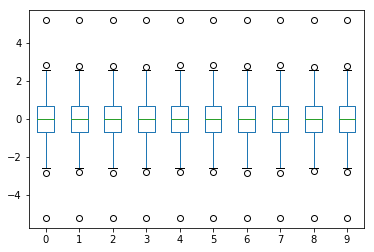

In [192]:
from sklearn.preprocessing import *
transformer = QuantileTransformer(output_distribution='normal')
fitted = transformer.fit(wide_scores.values)
pd.DataFrame(fitted.transform(wide_scores.values)).plot(kind='box')



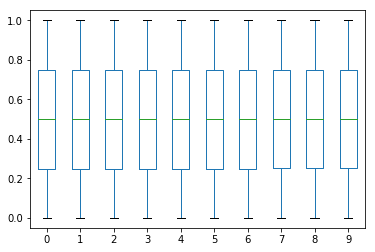

In [193]:
transformer = QuantileTransformer(output_distribution='uniform')
fitted = transformer.fit(wide_scores.values)
pd.DataFrame(fitted.transform(wide_scores.values)).plot(kind='box')

/Users/sfeygi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


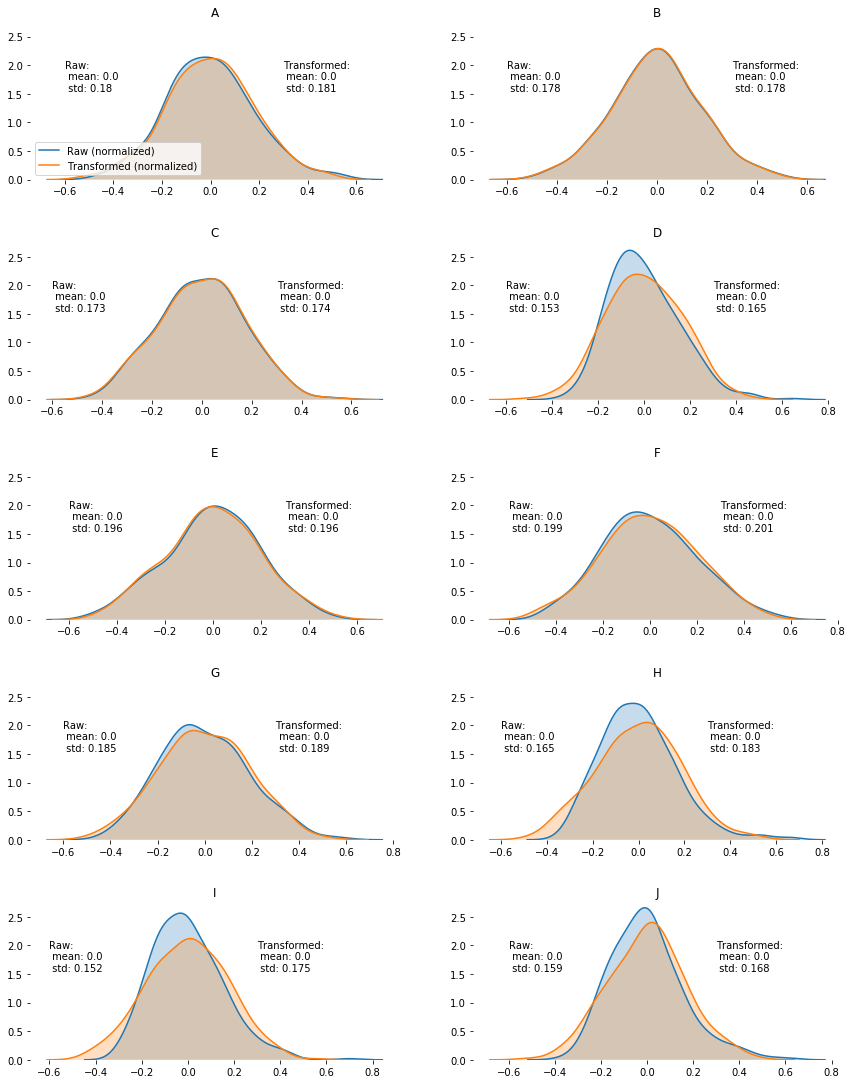

In [197]:
import scipy.stats as ss
fig,axes=plt.subplots(5,2,figsize=(12,15))
fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.4)

i = 0
for m in range(5):
    for n in range(2):
        ax = axes[m][n]
        x = wide_scores.T.iloc[i].values
        xt, maxlog, interval=ss.boxcox(x,alpha=0.05)

        x1=x.reshape(401)
        x1=(x1 - x1.mean()) / (x1.max() - x1.min())

        xt1=xt.reshape(401)
        xt1=(xt1 - xt1.mean()) / (xt1.max() - xt1.min())

        sns.kdeplot(x1, shade=True, label="Raw (normalized)" ,ax=ax);
        sns.kdeplot(xt1, shade=True, label="Transformed (normalized)" ,ax=ax);
        ax.set_frame_on(False)
        ax.set_title(columns[i])
        ax.set_ylim(0.0,2.75)
        ax.annotate('Raw:\n mean: 0.0\n std: {:.3}'.format(x1.std()),(-0.6,1.55))
        ax.annotate('Transformed:\n mean: 0.0\n std: {:.3}'.format(xt1.std()),(0.3,1.55))
        if i!=0:
            ax.get_legend().remove()
        else:
            ax.legend(loc='lower left')
        i+=1
#             plt.show()